# Imports

In [1]:
# import standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic lines
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#import my scripts
import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    scripts_path = os.path.join(module_path, "scripts")
    if scripts_path not in sys.path:
        sys.path.append(scripts_path)
    display(sys.path)
   
from data import get_data
from preprocessing import preprocess, add_new_columns

['/home/louis/code/lewagon/data/04-Decision-Science/01-Project-Setup/context-and-setup',
 '/home/louis/code/JammyNinja/Sandbox/chess_analysis/explore/notebooks',
 '/home/louis/.pyenv/versions/3.10.6/lib/python310.zip',
 '/home/louis/.pyenv/versions/3.10.6/lib/python3.10',
 '/home/louis/.pyenv/versions/3.10.6/lib/python3.10/lib-dynload',
 '',
 '/home/louis/.pyenv/versions/3.10.6/envs/chess_analysis/lib/python3.10/site-packages',
 '/home/louis/code/JammyNinja/Sandbox/chess_analysis/explore/scripts']

In [3]:
raw_data = get_data(df_name="all_games", descriptor="all_cols")
df = preprocess(raw_data)

In [4]:
fname = "all_games_2023-01_to_2024-12_all_new_cols.csv"
path = os.path.join("..", "data", fname)
os.path.getsize(path) / 1_000_000 #1_048_576

21.089538

In [5]:
# path = os.path.join("..", "data", "sample_raw_data.csv")
df = pd.read_csv(path)

In [6]:
df.iloc[0]

date                                                               2023-01-07
start_time                                                2023-01-07 08:17:06
end_time                                                  2023-01-07 14:35:53
time_class                                                              daily
time_control                                                         1/604800
rated                                                                    True
rules                                                                   chess
url                                https://www.chess.com/game/daily/437377841
moves                       1. e4 {[%clk 0:56:50.2] 1... c6 {[%clk 0:27:49...
opening_code                                                              B10
opening_name                        Caro-Kann-Defense-Hillbilly-Attack-2...d5
white_username                                                      sylvainau
black_username                                                  

### Exclude slower time formats

In [6]:
n_games_pre = len(df)
df = df.query("time_class == ['bullet']")
n_games_post = len(df)

print(f"excluded {n_games_pre - n_games_post} games.")

excluded 1708 games.


# Analysis

## General game end status
- how often do you resign?
- how often do you lose on time vs how often do your opponents?

-> pie chart

### mvp new columns

In [7]:
test = 53
display(df.iloc[test])

def get_user_result(row):
    """
        to be applied to df to generate new column
    """

    user_colour = row["user_colour"]
    user_result = row["white_result"] if user_colour == "white" else row["black_result"]
    opp_result  = row["white_result"] if user_colour == "black" else row["black_result"]

    user_rating = row["white_rating"] if user_colour == "white" else row["black_rating"]
    opp_rating  = row["white_rating"] if user_colour == "black" else row["black_rating"]
    
    data_out = {
        "user_result" : user_result,
        "opp_result"  : opp_result,
        # "user_rating": user_rating,
        "opp_rating" : opp_rating
    }
    return pd.Series(data_out)
    
get_user_result(df.iloc[test])

date                                                               2023-11-05
start_time                                                2023-11-05 23:12:56
end_time                                                  2023-11-05 23:15:02
time_class                                                             bullet
time_control                                                               60
rated                                                                    True
rules                                                                   chess
url                               https://www.chess.com/game/live/92964760061
moves                       1. d4 {[%clk 0:01:00] 1... c5 {[%clk 0:01:00] ...
opening_code                                                              A43
opening_name                                        Old-Benoni-Defense-2.dxc5
white_username                                                     JammyNinja
black_username                                                  

user_result    checkmated
opp_result            win
opp_rating            953
dtype: object

### game end status

In [8]:
game_results = df.apply(get_user_result, axis=1, result_type="expand")
game_results

,user_result,opp_result,opp_rating
38,win,timeout,277
39,win,timeout,277
40,checkmated,win,293
41,win,timeout,291
42,win,timeout,290
...,...,...,...
5392,checkmated,win,1357
5393,win,timeout,1276
5394,win,timeout,1268
5395,win,timeout,1306


In [9]:
df = pd.concat([df,game_results], axis=1)
df

,date,start_time,end_time,time_class,time_control,rated,rules,url,moves,opening_code,...,loser_pieces_only_count,pieces_count_diff,pawns_count_diff,winner_material_ttl,loser_material_ttl,winner_pcs,loser_pcs,user_result,opp_result,opp_rating
38,2023-09-13,2023-09-13 19:43:55,2023-09-13 19:46:41,bullet,60+1,True,chess,https://www.chess.com/game/live/88373362097,1. e4 {[%clk 0:01:01] 1... e5 {[%clk 0:01:01] ...,B07,...,4,0,0,26,28,"['q', 'k', 'p', 'n', 'p', 'p', 'p', 'p', 'r', ...","['P', 'Q', 'P', 'P', 'P', 'P', 'B', 'P', 'R', ...",win,timeout,277
39,2023-09-13,2023-09-13 19:47:02,2023-09-13 19:48:51,bullet,60+1,True,chess,https://www.chess.com/game/live/88373428625,1. e4 {[%clk 0:01:01] 1... e5 {[%clk 0:01:01] ...,C47,...,6,0,0,35,35,"['B', 'N', 'P', 'P', 'P', 'P', 'Q', 'P', 'P', ...","['k', 'r', 'r', 'p', 'p', 'q', 'p', 'p', 'p', ...",win,timeout,277
40,2023-09-13,2023-09-13 19:49:52,2023-09-13 19:52:32,bullet,60+1,True,chess,https://www.chess.com/game/live/88373489093,1. e4 {[%clk 0:01:01] 1... e5 {[%clk 0:01:01] ...,C20,...,5,0,1,32,31,"['Q', 'N', 'P', 'P', 'P', 'P', 'P', 'P', 'B', ...","['r', 'q', 'r', 'k', 'n', 'p', 'p', 'p', 'p', ...",checkmated,win,293
41,2023-09-13,2023-09-13 19:53:25,2023-09-13 19:55:47,bullet,60+1,True,chess,https://www.chess.com/game/live/88373952147,1. b3 {[%clk 0:01:01] 1... e5 {[%clk 0:01:01] ...,A01,...,4,1,-1,31,29,"['Q', 'P', 'P', 'R', 'P', 'N', 'B', 'P', 'P', ...","['r', 'r', 'k', 'b', 'p', 'p', 'q', 'p', 'p', ...",win,timeout,291
42,2023-09-13,2023-09-13 19:57:00,2023-09-13 20:00:14,bullet,60+1,True,chess,https://www.chess.com/game/live/88374025295,1. e4 {[%clk 0:01:01] 1... e5 {[%clk 0:01:01] ...,B07,...,5,0,0,29,29,"['b', 'q', 'n', 'p', 'p', 'k', 'r', 'p', 'p', ...","['N', 'P', 'P', 'P', 'P', 'P', 'B', 'N', 'P', ...",win,timeout,290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5392,2024-12-08,2024-12-08 20:06:45,2024-12-08 20:07:19,bullet,60,True,chess,https://www.chess.com/game/live/127427410181,1. d4 {[%clk 0:01:00] 1... d5 {[%clk 0:01:00] ...,D06,...,6,0,1,35,34,"['Q', 'P', 'P', 'P', 'N', 'P', 'B', 'B', 'P', ...","['r', 'r', 'k', 'n', 'n', 'p', 'p', 'p', 'q', ...",checkmated,win,1357
5393,2024-12-08,2024-12-08 20:07:22,2024-12-08 20:09:28,bullet,60,True,chess,https://www.chess.com/game/live/127427417455,1. e4 {[%clk 0:00:59.9] 1... c6 {[%clk 0:00:59...,B12,...,2,0,1,16,11,"['Q', 'P', 'P', 'P', 'P', 'B', 'K']","['n', 'r', 'p', 'p', 'k', 'p']",win,timeout,1276
5394,2024-12-08,2024-12-08 20:10:54,2024-12-08 20:13:04,bullet,60,True,chess,https://www.chess.com/game/live/127427458755,1. e4 {[%clk 0:01:00] 1... e5 {[%clk 0:00:59.5...,C25,...,2,0,-2,17,19,"['N', 'P', 'Q', 'P', 'P', 'P', 'P', 'K']","['p', 'p', 'p', 'k', 'p', 'p', 'p', 'n', 'p', ...",win,timeout,1268
5395,2024-12-08,2024-12-08 20:13:07,2024-12-08 20:15:09,bullet,60,True,chess,https://www.chess.com/game/live/127427967245,1. e4 {[%clk 0:01:00] 1... d5 {[%clk 0:01:00] ...,B01,...,3,0,0,16,16,"['r', 'k', 'p', 'p', 'p', 'p', 'p', 'b', 'n']","['N', 'N', 'P', 'P', 'P', 'P', 'K', 'P', 'R']",win,timeout,1306


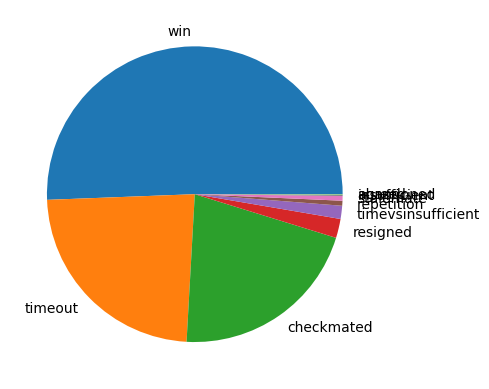

In [10]:
user_results = df.user_result.value_counts()
plt.pie(x = user_results.values, labels = user_results.index);

In [11]:
#of the games you won, how did you beat the opponent?
won_games = df.query("user_result == 'win'")
won_games.head(3)

,date,start_time,end_time,time_class,time_control,rated,rules,url,moves,opening_code,...,loser_pieces_only_count,pieces_count_diff,pawns_count_diff,winner_material_ttl,loser_material_ttl,winner_pcs,loser_pcs,user_result,opp_result,opp_rating
38,2023-09-13,2023-09-13 19:43:55,2023-09-13 19:46:41,bullet,60+1,True,chess,https://www.chess.com/game/live/88373362097,1. e4 {[%clk 0:01:01] 1... e5 {[%clk 0:01:01] ...,B07,...,4,0,0,26,28,"['q', 'k', 'p', 'n', 'p', 'p', 'p', 'p', 'r', ...","['P', 'Q', 'P', 'P', 'P', 'P', 'B', 'P', 'R', ...",win,timeout,277
39,2023-09-13,2023-09-13 19:47:02,2023-09-13 19:48:51,bullet,60+1,True,chess,https://www.chess.com/game/live/88373428625,1. e4 {[%clk 0:01:01] 1... e5 {[%clk 0:01:01] ...,C47,...,6,0,0,35,35,"['B', 'N', 'P', 'P', 'P', 'P', 'Q', 'P', 'P', ...","['k', 'r', 'r', 'p', 'p', 'q', 'p', 'p', 'p', ...",win,timeout,277
41,2023-09-13,2023-09-13 19:53:25,2023-09-13 19:55:47,bullet,60+1,True,chess,https://www.chess.com/game/live/88373952147,1. b3 {[%clk 0:01:01] 1... e5 {[%clk 0:01:01] ...,A01,...,4,1,-1,31,29,"['Q', 'P', 'P', 'R', 'P', 'N', 'B', 'P', 'P', ...","['r', 'r', 'k', 'b', 'p', 'p', 'q', 'p', 'p', ...",win,timeout,291


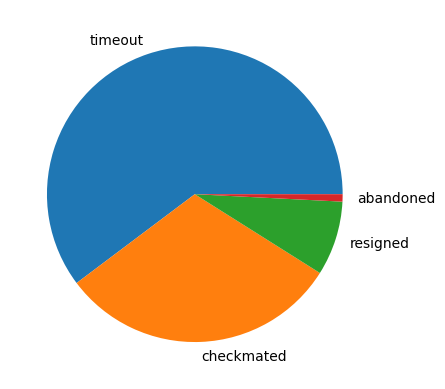

In [12]:
won_results = won_games.opp_result.value_counts()
plt.pie(x = won_results.values, labels = won_results.index);

## Rating over time


In [13]:
rating_df = df[["date", "user_rating"]].copy()
rating_df

,date,user_rating
38,2023-09-13,1079
39,2023-09-13,1082
40,2023-09-13,781
41,2023-09-13,797
42,2023-09-13,810
...,...,...
5392,2024-12-08,1313
5393,2024-12-08,1320
5394,2024-12-08,1327
5395,2024-12-08,1335


In [14]:
rating_df["date"] = pd.to_datetime(rating_df["date"])

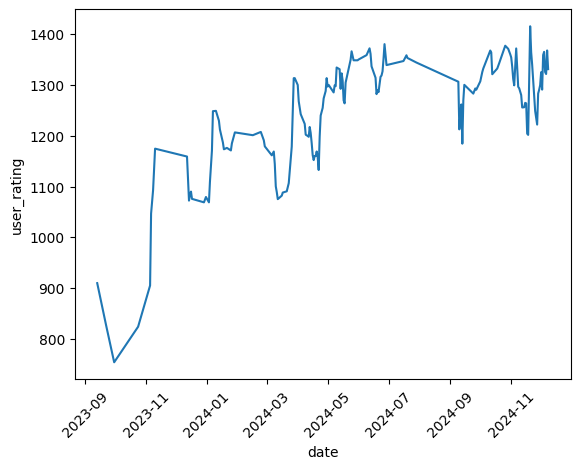

In [15]:
sns.lineplot(data=rating_df,
             x="date", y="user_rating", 
             errorbar=None)
plt.tick_params(axis="x", rotation=45)

## results vs opponents by rating range
every 50, what's your win/lose/draw split? - your 'true' rating is where it is about 50% 

In [16]:
cols = ["opp_rating", "user_result", "opp_result", "user_rating"]
opp_rating_df = df[cols].copy()
opp_rating_df

,opp_rating,user_result,opp_result,user_rating
38,277,win,timeout,1079
39,277,win,timeout,1082
40,293,checkmated,win,781
41,291,win,timeout,797
42,290,win,timeout,810
...,...,...,...,...
5392,1357,checkmated,win,1313
5393,1276,win,timeout,1320
5394,1268,win,timeout,1327
5395,1306,win,timeout,1335


In [17]:
bin_width = 50
min_bin = df.opp_rating.min() // bin_width * bin_width #round down to nearest 50
max_bin = df.opp_rating.max() // bin_width * bin_width + bin_width #round up to nearst 50

#printable
# list(range(min_bin, max_bin+1, bin_width))

bin_vals,bins_out = pd.cut(x=opp_rating_df["opp_rating"],
       bins =range(min_bin, max_bin+1, bin_width),
        retbins=True)
bins_out

array([ 250,  300,  350,  400,  450,  500,  550,  600,  650,  700,  750,
        800,  850,  900,  950, 1000, 1050, 1100, 1150, 1200, 1250, 1300,
       1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750])

In [18]:
opp_rating_df.loc[:,"opp_rating_range"] = bin_vals#.values

In [19]:
opp_rating_df

,opp_rating,user_result,opp_result,user_rating,opp_rating_range
38,277,win,timeout,1079,"(250, 300]"
39,277,win,timeout,1082,"(250, 300]"
40,293,checkmated,win,781,"(250, 300]"
41,291,win,timeout,797,"(250, 300]"
42,290,win,timeout,810,"(250, 300]"
...,...,...,...,...,...
5392,1357,checkmated,win,1313,"(1350, 1400]"
5393,1276,win,timeout,1320,"(1250, 1300]"
5394,1268,win,timeout,1327,"(1250, 1300]"
5395,1306,win,timeout,1335,"(1300, 1350]"


<Axes: xlabel='opp_rating_range'>

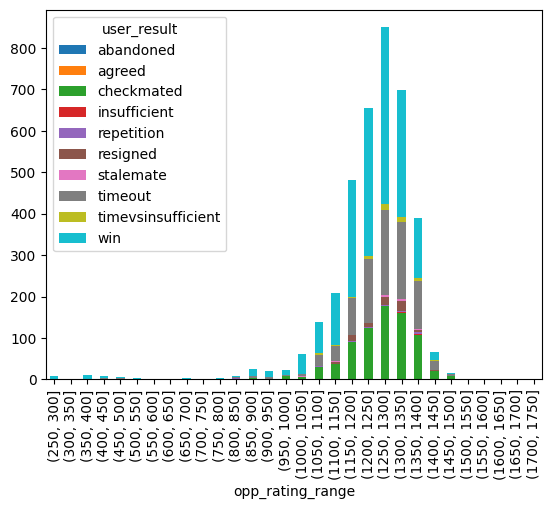

In [25]:
opp_rating_df.groupby(by="opp_rating_range", observed=False)["user_result"].value_counts().unstack().plot(kind="bar", stacked=True)

## MVP plan
- load raw data from a csv
- add only columns required
    - user colour
     - user result 
     - opp result 
     - user rating
     - opp rating
- display pie chart of how games end
- display bar chart with performance against different ratings


## mvp preproc

- work from local file (2024?)
    - sample_raw.csv 
- minimum clean (pipe!)
    - date to datetime 
- minimum new cols (pipe!)
    - user colour
    - user/opp rating
    - user/opp result 
- save to local file
    - sample_preproc.csv 

## Create sample raw data from the year 2023

to be used in mvp preproc

In [29]:
_ = os.path.join("..", "data", "sample_raw_data.csv")
_ = pd.read_csv(_)
_.iloc[0]

date                                                         2023-01-07
start_time                                          2023-01-07 08:17:06
end_time                                            2023-01-07 14:35:53
time_class                                                        daily
time_control                                                   1/604800
rated                                                              True
rules                                                             chess
url                          https://www.chess.com/game/daily/437377841
moves                 1. e4 {[%clk 158:31:38] 1... c6 {[%clk 163:21:...
final_position_fen    2r1k2r/pp3ppp/q7/4pb2/1b1P4/1P2B3/1P3PPP/K2R2N...
opening_code                                                        B10
opening_name                  Caro-Kann-Defense-Hillbilly-Attack-2...d5
white_username                                                sylvainau
black_username                                               Jam

In [48]:
from data import get_all_games_list

raw_list = get_all_games_list()

getting 2023/01
getting 2023/02
getting 2023/03
getting 2023/04
getting 2023/05
getting 2023/06
getting 2023/07
getting 2023/08
getting 2023/09
getting 2023/10
getting 2023/11
getting 2023/12
Downloaded a total of 882 games.


In [51]:
path_to_data = os.path.join("..", "data")
raw_pickle = "sample_raw.pkl"
pkl_path = os.path.join(path_to_data, raw_pickle)
pkl_path

'../data/sample_raw.pkl'

In [52]:
import pickle

In [56]:
! ls {path_to_data}

all_games_2023-01_to_2024-06_all_cols.csv
all_games_2023-01_to_2024-06_raw.csv
all_games_2023-01_to_2024-09_all_new_cols.csv
all_games_2023-01_to_2024-09_raw.csv
all_games_2023-01_to_2024-10_all_new_cols.csv
all_games_2023-01_to_2024-10_raw.csv
all_games_2023-01_to_2024-11_all_new_cols.csv
all_games_2023-01_to_2024-11_raw.csv
all_games_2023-01_to_2024-12_all_new_cols.csv
all_games_2023-01_to_2024-12_raw.csv
all_games_2024-04_to_2024-06_all_cols.csv
all_games_2024-04_to_2024-06_raw.csv
sample_raw_data.csv
sample_raw.pkl
select_games_2023-01_to_2024-06_select_cols.csv
select_games_2023-01_to_2024-09_select_cols.csv
select_games_2023-01_to_2024-10_select_cols.csv
select_games_2023-01_to_2024-11_select_cols.csv
select_games_2024-04_to_2024-06_select_cols.csv


In [55]:
with open (pkl_path, "wb") as file:
    pickle.dump(raw_list, file)

In [45]:
sample_path = os.path.join("..", "data", "sample_raw_data.csv")
sample_2023.to_csv(sample_path)